IMPORTAMOS LAS LIBRERÍAS

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import cv2
import json 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report


# Configuración para visualización de imágenes
%matplotlib inline

2024-07-03 19:11:06.211298: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


CARGAMOS EL ARCHIVO

In [2]:
photos = pd.read_json("photos.json", lines = True)

In [3]:
photos.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


In [4]:
photos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200100 entries, 0 to 200099
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   photo_id     200100 non-null  object
 1   business_id  200100 non-null  object
 2   caption      200100 non-null  object
 3   label        200100 non-null  object
dtypes: object(4)
memory usage: 6.1+ MB


TRAS LAS PRIMERAS CONCLUSIONES, HORA DE PROCEDER CON LA LIMPIEZA DEL DF

In [6]:
photos1 = photos.drop(columns=['caption']) #eliminamos la columna caption

In [7]:
photos1.head() #chequeamos la eliminación

,photo_id,business_id,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,food


In [8]:
def df_1(photo_id): #aplicamos un filtro para las imágenes corruptas del df
    try:
        Image.open(f"photos1/{photo_id}.jpg")
        return True
    except:
        return False

lista_images = photos1["photo_id"].to_list()
corrupt_images = []
for imagen in lista_images:
     if not df_1(imagen):
         corrupt_images.append(imagen)    
         
valid_photos = photos1[~photos1['photo_id'].isin(corrupt_images)]

valid_photos.to_json("valid_photos.json", orient="records", lines=True)     

In [9]:
photos2 = photos1.drop(columns=['business_id']) #photos2: sin la colunma de business id

In [10]:
photos2.head() #chequeamos 

,photo_id,label
0,zsvj7vloL4L5jhYyPIuVwg,inside
1,HCUdRJHHm_e0OCTlZetGLg,outside
2,vkr8T0scuJmGVvN2HJelEA,drink
3,pve7D6NUrafHW3EAORubyw,food
4,H52Er-uBg6rNrHcReWTD2w,food


In [11]:
photos2.info() #vemos cómo ha quedado todo tras la eliminación de las dos columnas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200100 entries, 0 to 200099
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   photo_id  200100 non-null  object
 1   label     200100 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


Tenemos más de 200.000 datos. Es hora de ver la proporción en las labels y determinar si procede suprimir datos de alguna de alguna de ellas (de forma aleatoria porque el df ya está limpio gracias al filtro aplicado). El fin es que el df no esté desproporcionado en sus distintas categorías de imágenes 

In [13]:
conteo_categorias = photos2['label'].value_counts() #contamos

print(conteo_categorias)

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64


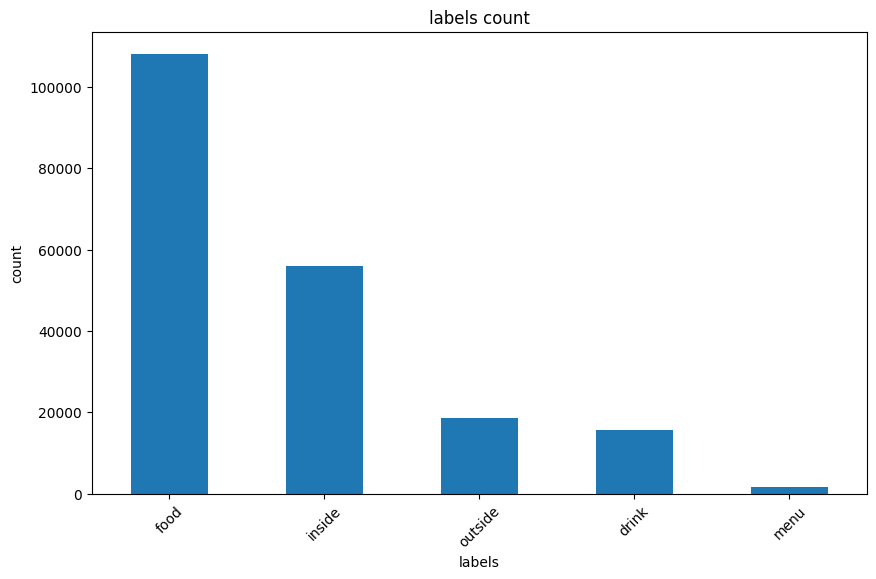

In [14]:
plt.figure(figsize=(10, 6))
conteo_categorias.plot(kind='bar')
plt.title('labels count')
plt.xlabel('labels')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

HAY MUCHA DESPROPORCIÓN EN LOS DATOS. TOCA AJUSTARLOS

In [15]:
print(conteo_categorias)

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64


In [16]:
def igualar1(photos2, etiqueta_columna, valor_columna, etiqueta_valor, num_filas):
    # Filtrar las filas que tienen la etiqueta específica
    filas_etiqueta = photos2[photos2[etiqueta_columna] == etiqueta_valor]
    
    # Verifica que num_filas no sea mayor que el total de filas con la etiqueta específica
    if num_filas > len(filas_etiqueta):
        raise ValueError("Error, coge un número más chico")
    
    # Seleccionar aleatoriamente los índices de las filas a eliminar
    indices_a_eliminar = np.random.choice(filas_etiqueta.index, num_filas, replace=False)
    
    # Eliminar las filas seleccionadas del dataset original
    photos3 = photos2.drop(indices_a_eliminar)
    
    return photos3 #photos3 se aplicará al df con la reducción de la etiqueta "food"

# Parámetros
etiqueta_columna = 'label'  # Nombre de la columna con la etiqueta
valor_columna = 'photo_id'       # Nombre de la columna con el valor asociado
etiqueta_valor = 'food'            # Valor específico de la etiqueta
num_filas = 106000                   # Número de filas a eliminar

# Eliminar filas con la etiqueta específica y su valor asociado
photos3 = igualar1(photos2, etiqueta_columna, valor_columna, etiqueta_valor, num_filas)





In [17]:
conteo_categorias2 = photos3['label'].value_counts() #una vez reducido food

print(conteo_categorias2)

label
inside     56031
outside    18569
drink      15670
food        2152
menu        1678
Name: count, dtype: int64


In [18]:
#A SEGUIR QUITANDO
def igualar2(photos3, etiqueta_columna, valor_columna, etiqueta_valor, num_filas):
    
    filas_etiqueta = photos3[photos3[etiqueta_columna] == etiqueta_valor]
    
    
    if num_filas > len(filas_etiqueta):
        raise ValueError("Error, coge un número más chico")
    
    
    indices_a_eliminar = np.random.choice(filas_etiqueta.index, num_filas, replace=False)
    
    
    photos4 = photos3.drop(indices_a_eliminar)
    
    return photos4 #photos4 se aplicará al df con la reducción de la etiqueta "inside"

# Parámetros
etiqueta_columna = 'label'  # Nombre de la columna con la etiqueta
valor_columna = 'photo_id'       # Nombre de la columna con el valor asociado
etiqueta_valor = 'inside'            # Valor específico de la etiqueta
num_filas = 53802                  # Número de filas a eliminar


photos4 = igualar2(photos3, etiqueta_columna, valor_columna, etiqueta_valor, num_filas)

In [19]:
conteo_categorias3 = photos4['label'].value_counts() #una vez reducido food

print(conteo_categorias3)

label
outside    18569
drink      15670
inside      2229
food        2152
menu        1678
Name: count, dtype: int64


In [20]:
#A SEGUIR QUITANDO, VAMOS CON OUTSIDE
def igualar3(photos4, etiqueta_columna, valor_columna, etiqueta_valor, num_filas):
    
    filas_etiqueta = photos4[photos4[etiqueta_columna] == etiqueta_valor]
    
    
    if num_filas > len(filas_etiqueta):
        raise ValueError("Error, coge un número más chico")
    
    
    indices_a_eliminar = np.random.choice(filas_etiqueta.index, num_filas, replace=False)
    
    
    photos5 = photos4.drop(indices_a_eliminar)
    
    return photos5 #photos5 se aplicará al df con la reducción de la etiqueta "outside"

# Parámetros
etiqueta_columna = 'label'  # Nombre de la columna con la etiqueta
valor_columna = 'photo_id'       # Nombre de la columna con el valor asociado
etiqueta_valor = 'outside'            # Valor específico de la etiqueta
num_filas = 16101                  # Número de filas a eliminar


photos5 = igualar3(photos4, etiqueta_columna, valor_columna, etiqueta_valor, num_filas)

In [21]:
conteo_categorias4 = photos5['label'].value_counts() #una vez reducido food

print(conteo_categorias4)

label
drink      15670
outside     2468
inside      2229
food        2152
menu        1678
Name: count, dtype: int64


In [22]:
#Ultimo DRINK
def igualar4(photos5, etiqueta_columna, valor_columna, etiqueta_valor, num_filas):
    
    filas_etiqueta = photos5[photos5[etiqueta_columna] == etiqueta_valor]
    
    
    if num_filas > len(filas_etiqueta):
        raise ValueError("Error, coge un número más chico")
    
    
    indices_a_eliminar = np.random.choice(filas_etiqueta.index, num_filas, replace=False)
    
    
    photos6 = photos5.drop(indices_a_eliminar)
    
    return photos6 #photos6 se aplicará al df con la reducción de la etiqueta "drink"

# Parámetros
etiqueta_columna = 'label'  # Nombre de la columna con la etiqueta
valor_columna = 'photo_id'       # Nombre de la columna con el valor asociado
etiqueta_valor = 'drink'            # Valor específico de la etiqueta
num_filas = 13020                 # Número de filas a eliminar


photos6 = igualar4(photos5, etiqueta_columna, valor_columna, etiqueta_valor, num_filas)

In [23]:
conteo_categorias5 = photos6['label'].value_counts() #una vez reducido food

print(conteo_categorias5)

label
drink      2650
outside    2468
inside     2229
food       2152
menu       1678
Name: count, dtype: int64


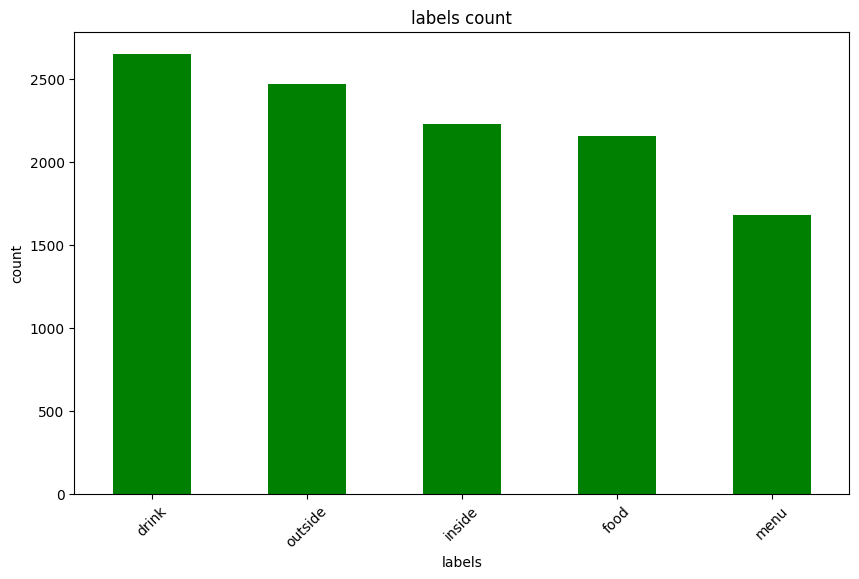

In [23]:
plt.figure(figsize=(10, 6))
conteo_categorias5.plot(kind='bar', color= 'green')
plt.title('labels count')
plt.xlabel('labels')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

AHORA LAS LABELS ESTÁN MÁS EQUILIBRADAS EN LA CANTIDAD DE DATOS QUE POSEEN

In [24]:
df_photos = photos6.copy() #hago una copia y lo renombro, por si las moscas

In [25]:
df_photos.tail()

,photo_id,label
200024,trzQEgH-YjsiOUZAZgBPRQ,food
200047,CysmQhYJ50TIIV4yh9Dy-w,outside
200064,wq2E-d6NuiCP5_DCC_6e6g,menu
200068,4cI_ZGkzyZnpTlwenTrpFA,food
200073,ZtuEsa-qc7gfy7m5UnfaZw,menu


In [36]:
def df_2(photo_id): #aplico el filtro otra vez porque quiero y puedo
    try:
        Image.open(f"df_photos/{photo_id}.jpg")
        return True
    except:
        return False

lista_images2 = df_photos["photo_id"].to_list()
corrupt_images2 = []
for imagen2 in lista_images2:
     if not df_2(imagen2):
         corrupt_images2.append(imagen)    
    
valid_photos = df_photos[~df_photos['photo_id'].isin(corrupt_images2)]

valid_photos.to_json("valid_photos.json", orient="records", lines=True)        

In [37]:
df_photos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11177 entries, 0 to 11176
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   photo_id  11177 non-null  object
 1   label     11177 non-null  object
dtypes: object(2)
memory usage: 174.8+ KB


In [38]:
df_photos.head(10) 

,photo_id,label
0,HCUdRJHHm_e0OCTlZetGLg,outside
1,9kVdBkGWcKfCFzSwUXjQyw,food
2,6LJa8QZOGBjt9maE5miLhw,menu
3,-kDGc-WTDMjZp6AGgVErVg,outside
4,DtsfhqhqUB-tjs5XbwJfXw,menu
5,tBFOXD-qPtXPYNWvyeWr0A,inside
6,a6dI4KTrWTnRZiglh62gKA,food
7,YkD4bbTV_wHr34oqDvWGhA,outside
8,cyzJVw9Xx5akGxmCqHlecw,drink
9,bHaMwNnEV90ZybXCQxSFow,inside


In [39]:
# Resetear el índice para que sea consecutivo porque vemos que las numeraciones de las filas están salteadas
df_photos.reset_index(drop=True, inplace=True)

# Mostrar el DataFrame con el índice reseteado
print("\nDataFrame con índice reseteado:")
print(df_photos.head(10))


DataFrame con índice reseteado:
                 photo_id    label
0  HCUdRJHHm_e0OCTlZetGLg  outside
1  9kVdBkGWcKfCFzSwUXjQyw     food
2  6LJa8QZOGBjt9maE5miLhw     menu
3  -kDGc-WTDMjZp6AGgVErVg  outside
4  DtsfhqhqUB-tjs5XbwJfXw     menu
5  tBFOXD-qPtXPYNWvyeWr0A   inside
6  a6dI4KTrWTnRZiglh62gKA     food
7  YkD4bbTV_wHr34oqDvWGhA  outside
8  cyzJVw9Xx5akGxmCqHlecw    drink
9  bHaMwNnEV90ZybXCQxSFow   inside


In [40]:
df_photos.tail(10) 

,photo_id,label
11167,x4acVHke3X7o6hrVaulmQA,menu
11168,6LfRv-UmRYnbJ-2627Gy9Q,drink
11169,US9Ut7owGXnuD4KLLbuRag,food
11170,X9PTTTfPCWclcHAptQlthQ,food
11171,8ZldnphijLWEvWWX6Y57Lg,menu
11172,trzQEgH-YjsiOUZAZgBPRQ,food
11173,CysmQhYJ50TIIV4yh9Dy-w,outside
11174,wq2E-d6NuiCP5_DCC_6e6g,menu
11175,4cI_ZGkzyZnpTlwenTrpFA,food
11176,ZtuEsa-qc7gfy7m5UnfaZw,menu


TRAS VER QUE TODO ESTÁ CORRECTO, HORA DE ABRIR LAS FOTOS Y VER QUE TODO ESTÁ OK EN LA APERTURA :) 

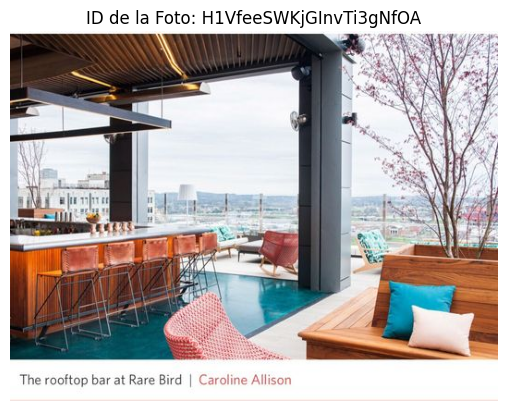

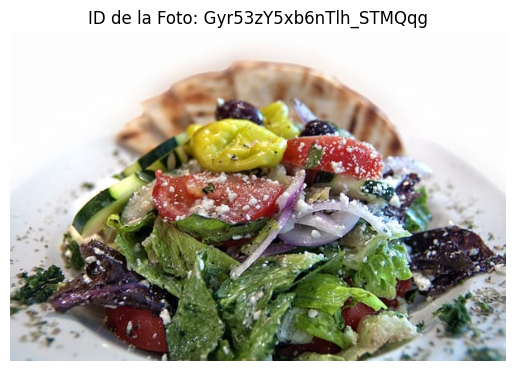

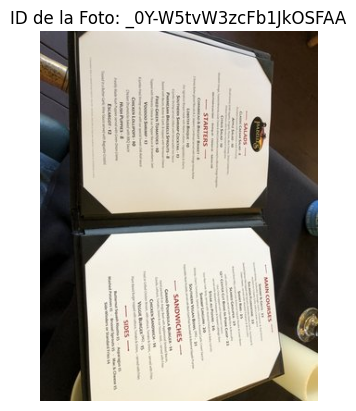

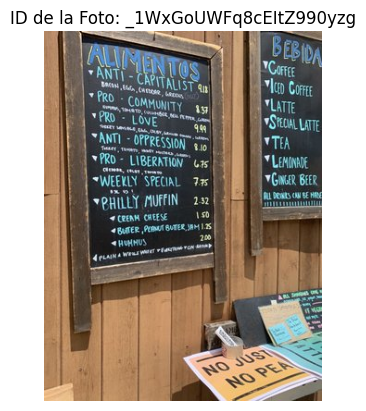

In [41]:
# Carpeta donde se encuentran las imágenes (pon la ubicación de tu carpeta)
image_folder = '/Users/florentinoromerourquiza/Documents/yelp_photos-002/photos'

photo_ids = df_photos['photo_id']

# el número de fotos que quieres que aparezcan al ejecutar esta celda (apareceran de forma aleatoria)
num_photos = 4

# Variable para seleccionar aleatoriamente las IDs de las fotos
random_photo_ids = random.sample(list(photo_ids), num_photos)

for photo_id in random_photo_ids:
    
    image_path = os.path.join(image_folder, f'{photo_id}.jpg')
    
    img = Image.open(image_path)
    
    plt.imshow(img)
    plt.title(f'ID de la Foto: {photo_id}')
    plt.axis('off')
    plt.show()

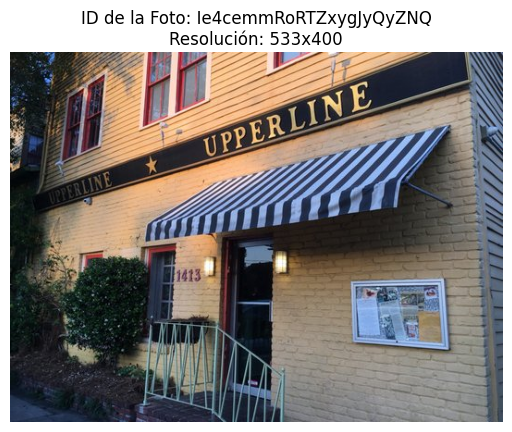

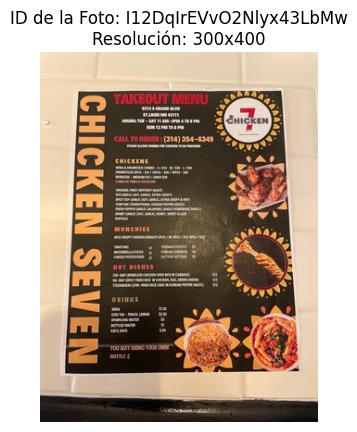

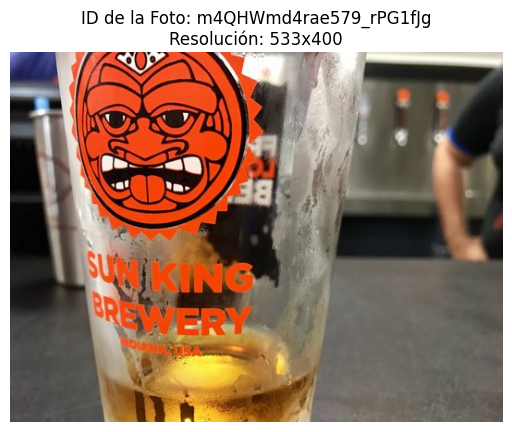

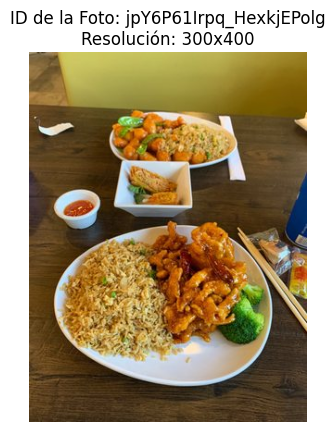

In [42]:
# Variable para seleccionar aleatoriamente las IDs de las fotos
random_photo_ids = random.sample(list(photo_ids), num_photos)

for photo_id in random_photo_ids:
    image_path = os.path.join(image_folder, f'{photo_id}.jpg')
    
    try:
        img = Image.open(image_path)
        width, height = img.size
        
        plt.imshow(img)
        plt.title(f'ID de la Foto: {photo_id}\nResolución: {width}x{height}')
        plt.axis('off')
        plt.show()
        
    except (IOError, SyntaxError) as e:
        print(f"El archivo {image_path} no es una imagen válida o está corrupto: {e}")


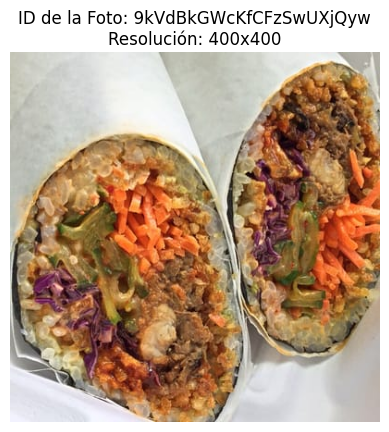

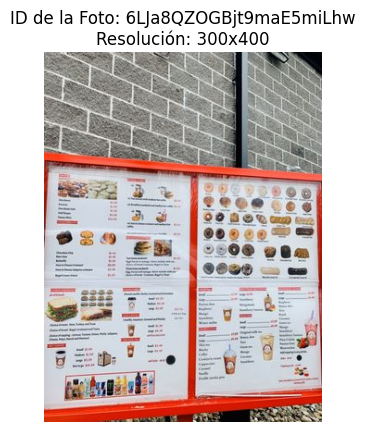

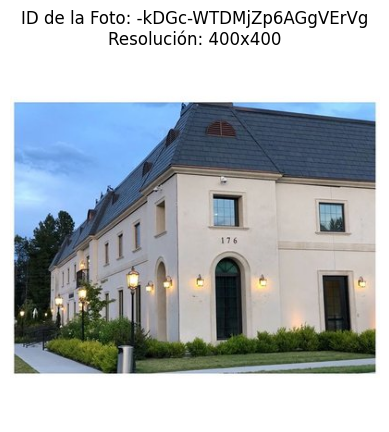

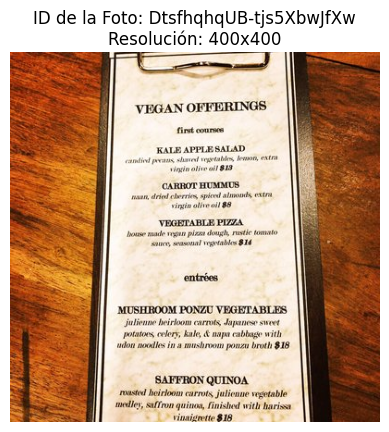

In [43]:
def mostrar_fotos(df, image_folder, start_index, end_index):
    # Obtener las IDs de las fotos dentro del rango especificado
    photo_ids = df['photo_id'][start_index:end_index+1]
    
    for photo_id in photo_ids:
        image_path = os.path.join(image_folder, f'{photo_id}.jpg')
        
        try:
            img = Image.open(image_path)
            width, height = img.size
            
            plt.imshow(img)
            plt.title(f'ID de la Foto: {photo_id}\nResolución: {width}x{height}')
            plt.axis('off')
            plt.show()
            
        except (IOError, SyntaxError) as e:
            print(f"El archivo {image_path} no es una imagen válida o está corrupto: {e}")

# Carpeta donde se encuentran las imágenes (pon la ubicación de tu carpeta)
image_folder = '/Users/florentinoromerourquiza/Documents/yelp_photos-002/photos'

# Ejemplo de uso: seleccionar fotos desde el índice 4 hasta el 10 o hasta donde digas
mostrar_fotos(df_photos, image_folder, 1, 4)

ENTRENAMIENTO ML mobile net

PASO 1: Preparación de Datos

In [ ]:
import os
import pandas as pd
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Función para cargar imágenes y etiquetas
def load_images_and_labels(df, image_folder):
    images = []
    labels = []
    
    for index, row in df.iterrows():
        image_path = os.path.join(image_folder, f"{row['photo_id']}.jpg")
        try:
            img = Image.open(image_path).resize((224, 224)).convert('RGB')  # Asegúrate de que la imagen está en RGB
            images.append(np.array(img))
            labels.append(row['label'])
        except (IOError, SyntaxError) as e:
            print(f"El archivo {image_path} no es una imagen válida o está corrupto: {e}")
    
    return np.array(images), np.array(labels)

# Carpeta donde se encuentran las imágenes
image_folder = '/Users/florentinoromerourquiza/Documents/yelp_photos-002/photos'

# Cargar las imágenes y las etiquetas
images, labels = load_images_and_labels(df_photos, image_folder)

# Codificar las etiquetas
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded, num_classes=5)  # Asegúrate de especificar 5 clases

print(f"Shape of images: {images.shape}")
print(f"Shape of labels: {labels_encoded.shape}")

PASO 2: CONSTRUCCIÓN DEL MODELO

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Cargar la base del modelo MobileNetV2 preentrenado
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas base del modelo
base_model.trainable = False

# Añadir nuestras capas superiores
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)  # Ajuste para 5 clases

model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Paso 3: Entrenamiento del Modelo

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

# Aumento de datos
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Ajustar el generador de datos al conjunto de entrenamiento
datagen.fit(X_train)

# Calcular el número de pasos por época
batch_size = 32
steps_per_epoch = len(X_train) // batch_size

# Entrenar el modelo
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    validation_data=(X_test, y_test))

EVALUACIÓN

In [ ]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calcular el F1-score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f'F1-score: {f1}')

# Calcular el accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Generar el reporte de clasificación
report = classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_)
print(report)

# Generar la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotear todas las curvas ROC
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


PREDICCIÓN

In [ ]:
def predict_image(model, image_path, label_encoder):
    img = Image.open(image_path).resize((224, 224)).convert('RGB')
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Añadir una dimensión para el batch

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    predicted_label = label_encoder.inverse_transform(predicted_class)
    
    return predicted_label[0]

# Prueba de predicción
image_path = '/Users/florentinoromerourquiza/Documents/yelp_photos-002/photos/some_image.jpg'
predicted_label = predict_image(model, image_path, label_encoder)
print(f"La etiqueta predicha para la imagen es: {predicted_label}")